

# Deep Learning Project 3 - Patryk Prusak,  Dutt Salveen Singh






# Imports and consts

In [1]:
IS_IN_COLAB = False
# If the background noise is not split (it's in its original form) set it to False
BG_IS_ALREADY_SPLIT = False

In [2]:
if IS_IN_COLAB:
    !pip install pydub
    !pip install faster_whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.3 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Reshape, Dropout
from keras.optimizers import Adam, SGD, Lion
from keras.regularizers import L2
import keras.regularizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import shutil
import random
import pickle
import pandas as pd
from enum import Enum
from pydub import AudioSegment
from faster_whisper import WhisperModel

In [4]:
if IS_IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    !7z x /content/drive/'My Drive'/Studia/Masters/DeepLearning/Project2/Dataset/train.7z -o/content/dataset/

Mounted at /content/drive

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/Studia/Masters/DeepLearning/Project2/Dataset/                                                                               1 file, 1121103842 bytes (1070 MiB)

Extracting archive: /content/drive/My Drive/Studia/Masters/DeepLearning/Project2/Dataset/train.7z
--
Path = /content/drive/My Drive/Studia/Masters/DeepLearning/Project2/Dataset/train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38 - train/audio/_background_noise_/doing_the_dishes.wav

In [5]:
# !7z x /content/drive/'My Drive'/Studia/Masters/DeepLearning/Project2/Dataset/test.7z -o/content/dataset/

In [6]:
if IS_IN_COLAB:
    DATASET_DIR = "/content/dataset/train/audio/"
else:
    DATASET_DIR = "../Dataset/train/audio/"
# DATASET_DIR_TEST = '/content/dataset/test/audio/'

# Helper Functions

In [7]:
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISM"] = "1"
    os.environ["PYTHONHASHSEED"] = str(seed)

In [8]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(
        audio,
        fs=sample_rate,
        window="hann",
        nperseg=nperseg,
        noverlap=noverlap,
        detrend=False,
    )
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [9]:
def preprocess_data(row, num_classes):
    signal_path = DATASET_DIR + row["label_name"] + "/" + row["path"]
    samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    img = cv2.resize(spectrogram, (32, 32))
    img = np.divide((img - np.mean(img)), np.std(img), out=img, where=np.std(img) != 0)
    img = np.stack((img,) * 3, axis=-1).astype(np.float32)
    label = np.zeros(num_classes)
    label[row["label"]] = 1
    return img, label


def create_dataset(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
        ),
    )
    # dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(2)
    return dataset

In [10]:
def split_audio_file(input_file, output_dir, split_length=1000, overlap=0.99):
    audio = AudioSegment.from_wav(input_file)
    file_name = os.path.basename(input_file)
    file_name_no_extension = os.path.splitext(file_name)[0]

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Calculate the overlap duration
    overlap_duration = int(split_length * overlap)

    # Split the audio with overlap
    start_time = 0
    end_time = split_length
    i = 1
    while end_time < len(audio):
        chunk = audio[start_time:end_time]
        chunk.export(
            os.path.join(output_dir, f"{file_name_no_extension}_{i}.wav"), format="wav"
        )
        i += 1
        start_time = end_time - overlap_duration
        end_time = start_time + split_length

In [11]:
def count_files(directory):
    if os.path.exists(directory):
        return len(
            [
                name
                for name in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, name))
            ]
        )
    else:
        return 0

# Prepare data

## Load data without background noise

In [12]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labels = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind

df = pd.DataFrame(data_map.values(), columns=["label_name", "path", "label"])
df = df.set_index(["label_name", "label"])
df.reset_index(inplace=True)
# background = df[df['label_name'] == '_background_noise_']
df = df[df["label_name"] != "_background_noise_"]
element_to_remove = "_background_noise_"
if element_to_remove in labels:
    labels.remove(element_to_remove)


rows = []
_ = df.apply(
    lambda row: [rows.append([row["label_name"], row["label"], nn]) for nn in row.path],
    axis=1,
)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r"speech_commands_dataset_all_labels.csv", index=True)


df_new["label"] = df_new["label"].apply(lambda x: x if x < 12 else x - 1)

In [13]:
data = df_new

In [14]:
input_shape = (32, 32, 3)
num_classes = len(labels)

## Split Background Noise

In [15]:
BKGRND_DIR = os.path.join(DATASET_DIR, "_background_noise_original")
OUTPUT_DIR = os.path.join(DATASET_DIR, "_background_noise_")

In [16]:
if not BG_IS_ALREADY_SPLIT:
    os.rename(OUTPUT_DIR, BKGRND_DIR)

In [17]:
if not BG_IS_ALREADY_SPLIT:
    for root, dirs, files in os.walk(BKGRND_DIR):
        for file in files:
            if file.endswith(".wav"):
                input_file_path = os.path.join(root, file)
                split_audio_file(input_file_path, OUTPUT_DIR)

In [18]:
if not BG_IS_ALREADY_SPLIT:
    shutil.rmtree(BKGRND_DIR)

In [19]:
# Count files in the output directory
num_files = count_files(OUTPUT_DIR)
print("Number of files in the output directory:", num_files)

Number of files in the output directory: 39342


## Load data with split background noise

In [20]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labelsBackgroundNoise = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labelsBackgroundNoise):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labelsBackgroundNoise):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind

dfBackgroundNoise = pd.DataFrame(
    data_map.values(), columns=["label_name", "path", "label"]
)
dfBackgroundNoise = dfBackgroundNoise.set_index(["label_name", "label"])
dfBackgroundNoise.reset_index(inplace=True)


rows = []
_ = dfBackgroundNoise.apply(
    lambda row: [rows.append([row["label_name"], row["label"], nn]) for nn in row.path],
    axis=1,
)
dfBackgroundNoise_new = pd.DataFrame(rows, columns=dfBackgroundNoise.columns)
dfBackgroundNoise_new.to_csv(
    r"speech_commands_dataset_with_bg_noise_labels.csv", index=True
)

In [21]:
input_shape = (32, 32, 3)
num_classes_with_bg_noise = len(labelsBackgroundNoise)

In [22]:
dfBackgroundNoise_new.head(5)

,label_name,label,path
0,marvin,0,bfbd0e6b_nohash_0.wav
1,marvin,0,cb8f8307_nohash_0.wav
2,marvin,0,66774579_nohash_1.wav
3,marvin,0,0d53e045_nohash_0.wav
4,marvin,0,2a0b413e_nohash_0.wav


In [23]:
dfBackgroundNoise_new.groupby("label_name").count()

,label,path
label_name,,
_background_noise_,39342,39342
bed,1713,1713
bird,1731,1731
cat,1733,1733
dog,1746,1746
down,2359,2359
eight,2352,2352
five,2357,2357
four,2372,2372


In [24]:
dfBackgroundNoise_new[
    dfBackgroundNoise_new["label_name"] != "_background_noise_"
].groupby("label_name").count().mean()

label    2157.366667
path     2157.366667
dtype: float64

In [25]:
dfBackgroundNoise_new = (
    dfBackgroundNoise_new.groupby("label").head(2157).reset_index(drop=True)
)

In [26]:
dfBackgroundNoise_new.groupby("label_name").count()

,label,path
label_name,,
_background_noise_,2157,2157
bed,1713,1713
bird,1731,1731
cat,1733,1733
dog,1746,1746
down,2157,2157
eight,2157,2157
five,2157,2157
four,2157,2157


In [27]:
onlyBackgroundNoise = dfBackgroundNoise_new[
    dfBackgroundNoise_new["label_name"] == "_background_noise_"
]
normalisedBinaryBackgroundNoise = (
    dfBackgroundNoise_new[dfBackgroundNoise_new["label_name"] != "_background_noise_"]
    .groupby("label_name")
    .head(72)
    .reset_index(drop=True)
)
normalisedBinaryBackgroundNoise = pd.concat(
    [onlyBackgroundNoise, normalisedBinaryBackgroundNoise]
)

In [28]:
normalisedBinaryBackgroundNoise.groupby("label_name").count()

,label,path
label_name,,
_background_noise_,2157,2157
bed,72,72
bird,72,72
cat,72,72
dog,72,72
down,72,72
eight,72,72
five,72,72
four,72,72


# LSTM Test

In [ ]:
epochs = 10
batch_size = 128
learning_rate = 0.001

In [ ]:
model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Reshape((-1, 128)),
        LSTM(128),
        Dense(num_classes, activation="softmax"),
    ]
)
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [ ]:
train_df, val_df = train_test_split(data, stratify=data["label"], test_size=0.1)
train_df, test_df = train_test_split(
    train_df, stratify=train_df["label"], test_size=0.1
)
print(train_df.shape, val_df.shape)
print(train_df.dtypes)
print(train_df.head())

(52423, 3) (6473, 3)
label_name    object
label          int64
path          object
dtype: object
      label_name  label                   path
25790       tree     11  44fb4274_nohash_0.wav
20386       five      9  6fca237d_nohash_2.wav
16159        one      7  da7689f1_nohash_0.wav
16314        one      7  2fa39636_nohash_0.wav
61279      right     28  f5733968_nohash_0.wav


In [ ]:
train_dataset = create_dataset(train_df, num_classes, batch_size)
val_dataset = create_dataset(val_df, num_classes, batch_size)

In [ ]:
model.fit(
    train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset
)

Epoch 1/10
410/410 [==============================] - 100s 203ms/step - loss: 1.6526 - accuracy: 0.5178 - val_loss: 0.9411 - val_accuracy: 0.7123
Epoch 2/10
410/410 [==============================] - 82s 200ms/step - loss: 0.7271 - accuracy: 0.7825 - val_loss: 0.6808 - val_accuracy: 0.7979
Epoch 3/10
410/410 [==============================] - 82s 199ms/step - loss: 0.5407 - accuracy: 0.8368 - val_loss: 0.6063 - val_accuracy: 0.8219
Epoch 4/10
410/410 [==============================] - 82s 200ms/step - loss: 0.4410 - accuracy: 0.8665 - val_loss: 0.5352 - val_accuracy: 0.8409
Epoch 5/10
410/410 [==============================] - 82s 200ms/step - loss: 0.3773 - accuracy: 0.8847 - val_loss: 0.5384 - val_accuracy: 0.8426
Epoch 6/10
410/410 [==============================] - 82s 201ms/step - loss: 0.3323 - accuracy: 0.8988 - val_loss: 0.5072 - val_accuracy: 0.8511
Epoch 7/10
410/410 [==============================] - 82s 199ms/step - loss: 0.2989 - accuracy: 0.9079 - val_loss: 0.5288 - val_a

In [ ]:
test_data = create_dataset(test_df, num_classes, batch_size)

In [ ]:
result = model.predict(test_data)

46/46 [==============================] - 9s 183ms/step


In [ ]:
y_pred = np.argmax(result, axis=1)

In [ ]:
y_true = []
for index, row in test_df.iterrows():
    y_true.append(row["label"])

In [ ]:
correct = 0
for i, y in enumerate(y_pred):
    if y == y_true[i]:
        correct += 1
correct / len(y_true)

0.8624892703862661

Accuracy: 0.8624892703862661


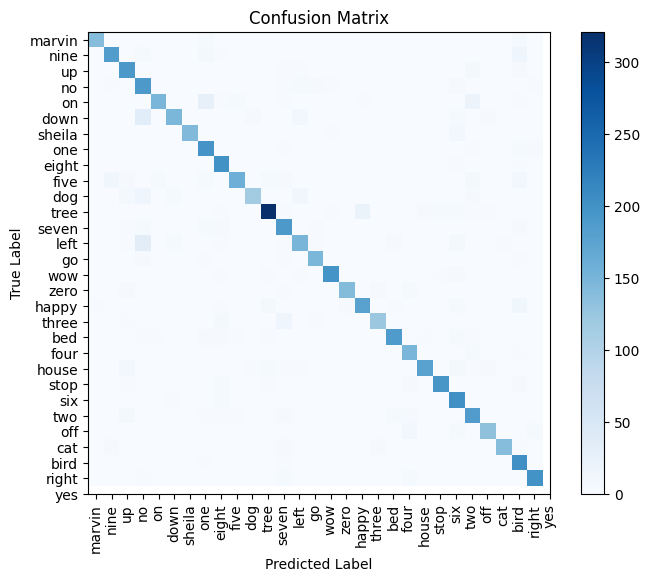

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Set tick labels
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels, rotation=0)
plt.show()

# Experiments Pipeline


## Functions and classes

In [48]:
class AugmentationTechnique(Enum):
    NoAugmentation = 0
    Tempo = 1
    Echo = 2
    Noise = 3


class ModelType(Enum):
    LSTM = 1
    Transformer = 2
    LSTM_BG = 3
    CustomLSTMShort = 4


class OptimizerType(Enum):
    Adam = 1
    Sgd = 2
    Lion = 3


class RegularizationType(Enum):
    NoRegularization = 1
    L2 = 2
    Dropout = 3


def getRegularizer(regularizerType, value):
    match regularizerType:
        case RegularizationType.L2:
            return L2(value)


def getDenseLayer(model, regularization, activation, nodes):
    match regularization["type"]:
        case RegularizationType.Dropout:
            model.add(Dropout(rate=regularization["value"]))
            model.add(Dense(nodes, activation=activation))
        case RegularizationType.NoRegularization:
            model.add(Dense(nodes, activation=activation))
        case RegularizationType.L2:
            model.add(
                Dense(
                    nodes,
                    activation=activation,
                    kernel_regularizer=getRegularizer(
                        regularizerType=regularization["type"],
                        value=regularization["value"],
                    ),
                )
            )


def getAugmentationLayer(model, technique, seed):
    match technique:
        case AugmentationTechnique.NoAugmentation:
            return


class Model:
    def fit(
        self, batch_size, epochs, train_images, train_labels, valid_images, valid_labels
    ):
        pass

    def predict(self, test_images):
        pass

    def __init__(self, optimizer, loss, metrics):
        pass


class CustomLSTM(Model):
    def __init__(
        self, optimizer, loss, metrics, regularizer, seed, augmentation, num_classes
    ):
        self.model = Sequential(
            [
                Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
                MaxPooling2D((2, 2)),
                Conv2D(64, (3, 3), activation="relu"),
                MaxPooling2D((2, 2)),
                Conv2D(128, (3, 3), activation="relu"),
                MaxPooling2D((2, 2)),
                Flatten(),
                Reshape((-1, 128)),
                LSTM(128),
                Dense(num_classes, activation="softmax"),
            ]
        )
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, batch_size, epochs, train_dataset, val_dataset):
        return self.model.fit(
            train_dataset,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=val_dataset,
        )

    def predict(self, test_df):
        result = self.model.predict(test_df)
        return np.argmax(result, axis=1)


class CustomLSTMShort(Model):
    def __init__(
        self, optimizer, loss, metrics, regularizer, seed, augmentation, num_classes
    ):
        self.model = Sequential(
            [
                Flatten(),
                Reshape((-1, 128)),
                LSTM(128),
                Dense(num_classes, activation="softmax"),
            ]
        )
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, batch_size, epochs, train_dataset, val_dataset):
        return self.model.fit(
            train_dataset,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=val_dataset,
        )

    def predict(self, test_df):
        result = self.model.predict(test_df)
        return np.argmax(result, axis=1)


class CustomLSTMBackgroundNoise(Model):
    def __init__(
        self, optimizer, loss, metrics, regularizer, seed, augmentation, num_classes
    ):
        self.model = Sequential(
            [
                Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
                MaxPooling2D((2, 2)),
                Conv2D(64, (3, 3), activation="relu"),
                Dropout(0.2),
                MaxPooling2D((2, 2)),
                Conv2D(128, (3, 3), activation="relu"),
                Dropout(0.2),
                MaxPooling2D((2, 2)),
                Flatten(),
                Reshape((-1, 128)),
                LSTM(128),
                Dropout(0.2),
                Dense(
                    1,
                    activation="sigmoid",
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
                    bias_regularizer=keras.regularizers.L2(1e-4),
                    activity_regularizer=keras.regularizers.L2(1e-5),
                ),
            ]
        )

        self.model.compile(
            optimizer=optimizer, loss="binary_crossentropy", metrics=metrics
        )

    def fit(self, batch_size, epochs, train_dataset, val_dataset):
        return self.model.fit(
            train_dataset,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=val_dataset,
        )

    def predict(self, test_df):
        result = self.model.predict(test_df)
        return np.argmax(result, axis=1)

In [49]:
def createModel(
    modelType, optimizer, loss, metrics, regularizer, seed, augmentation, num_classes
) -> Model:
    match modelType:
        case ModelType.LSTM:
            return CustomLSTM(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics,
                regularizer=regularizer,
                seed=seed,
                augmentation=augmentation,
                num_classes=num_classes,
            )
        case ModelType.CustomLSTMShort:
            return CustomLSTMShort(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics,
                regularizer=regularizer,
                seed=seed,
                augmentation=augmentation,
                num_classes=num_classes,
            )
        case ModelType.LSTM_BG:
            return CustomLSTMBackgroundNoise(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics,
                regularizer=regularizer,
                seed=seed,
                augmentation=augmentation,
                num_classes=num_classes,
            )


def getOptimizer(optimizer_type, learningRate):
    match optimizer_type:
        case OptimizerType.Adam:
            return Adam(learning_rate=learningRate)
        case OptimizerType.Sgd:
            return SGD(learning_rate=learningRate)
        case OptimizerType.Lion:
            return Lion(learning_rate=learningRate)

In [50]:
def preprocess_background_data(row):
    signal_path = DATASET_DIR + row["label_name"] + "/" + row["path"]
    samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    img = cv2.resize(spectrogram, (32, 32))
    img = np.divide((img - np.mean(img)), np.std(img), out=img, where=np.std(img) != 0)
    img = np.stack((img,) * 3, axis=-1).astype(np.float32)
    label = np.array([row["label"]], dtype=np.float32)
    return img, label

In [51]:
def create_dataset_lstm(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
        ),
    )
    # dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(2)
    return dataset


def create_dataset_background_lstm(df, num_classes, batch_size):
    df_gen = df.copy()
    df_gen["label"] = df_gen["label_name"].apply(
        lambda x: 1 if x == "_background_noise_" else 0
    )

    def generator():
        for index, row in df_gen.iterrows():
            img, label = preprocess_background_data(row)
            yield img, label

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(1,), dtype=tf.float32),
        ),
    )
    # dataset = dataset.shuffle(buffer_size=len(df_gen))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(2)
    return dataset


def getDatasetGenerator(modelType, df, num_classes, batch_size):
    match (modelType):
        case ModelType.LSTM:
            return create_dataset_lstm(df, num_classes, batch_size)
        case ModelType.CustomLSTMShort:
            return create_dataset_lstm(df, num_classes, batch_size)
        case ModelType.LSTM_BG:
            return create_dataset_background_lstm(df, num_classes, batch_size)

In [52]:
def reduceDataset(df, percentToKeep):
    return (
        df.groupby("label")
        .head(int(df.shape[0] * float(percentToKeep / 100) / num_classes))
        .reset_index(drop=True)
    )

In [53]:
def performSingleExperiment(
    modelType,
    batchSize,
    epochNumber,
    augmentation,
    learningRate,
    seed,
    optimizerType,
    num_classes,
    train_data,
    val_data,
    test_split_dataset,
    split,
    regularizer,
):
    # print(f"Performing experiment with model: {modelType}, batch size: {batchSize}, epochs: {epochNumber}, augmentation: {augmentation}, regularizer: {regularizer}, learning rate: {learningRate}, seed: {seed}")
    print(
        f"Performing experiment with model: {modelType}, batch size: {batchSize}, epochs: {epochNumber}, augmentation: {augmentation}, regularization: {regularizer['type'].name},learning rate: {learningRate}, seed: {seed}, optimizer: {optimizerType.name}, split: {split}"
    )
    set_seed(seed)
    train_dataset = getDatasetGenerator(
        modelType, reduceDataset(train_data, 20), num_classes, batchSize
    )
    val_dataset = getDatasetGenerator(
        modelType, reduceDataset(val_data, 20), num_classes, batchSize
    )
    model = createModel(
        num_classes=num_classes,
        modelType=modelType,
        regularizer={"type": regularizer["type"], "value": regularizer["value"]},
        optimizer=getOptimizer(optimizer_type=optimizerType, learningRate=learningRate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
        seed=seed,
        augmentation=augmentation,
    )
    # train the model
    history = model.fit(
        batch_size=batchSize,
        epochs=epochNumber,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
    )

    # get accuracy
    test_split_dataset_generator = getDatasetGenerator(
        modelType, test_split_dataset, num_classes, batchSize
    )
    y_pred = model.predict(test_split_dataset_generator)
    y_true = []
    if modelType == ModelType.LSTM_BG:
        for index, row in test_split_dataset.iterrows():
            if row["label_name"] == "_background_noise_":
                y_true.append(1)
            else:
                y_true.append(0)
    else:
        for index, row in test_split_dataset.iterrows():
            y_true.append(row["label"])

    accuracy = accuracy_score(y_true, y_pred)
    return [
        accuracy,
        augmentation,
        optimizerType,
        batchSize,
        learningRate,
        epochNumber,
        seed,
        split,
        regularizer,
        modelType,
    ], history


def performExperiment(
    batchSizes,
    learningRates,
    numberOfEpochs,
    augmentationTechniques,
    regularizers,
    modelType,
    seeds,
    optimizers,
    num_classes,
    trainData,
    splits,
):
    results = []
    histories = []
    accuracy = 0
    accuracyMean = 0
    accuracyArray = []
    train_split_dataset, val_split_dataset = train_test_split(
        trainData, stratify=trainData["label"], test_size=0.1
    )
    train_split_dataset, test_split_dataset = train_test_split(
        train_split_dataset, stratify=train_split_dataset["label"], test_size=splits[0]
    )

    currentBestBatchSize = batchSizes[0]
    currentBestLearningRate = learningRates[0]
    currentBestNumberOfEpochs = 10
    lastExperimentNumberOfEpochs = 50
    currentBestAugmentation = augmentationTechniques[0]
    currentBestOptimizer = optimizers[0]
    currentBestSplit = splits[0]
    currentBestRegularizer = regularizers[0]
    bestSeed = seeds[0]
    tempSeed = seeds[0]
    bestSeedAccuracy = 0
    tempSeedAccuracy = 0

    for seed in seeds:

        result, history = performSingleExperiment(
            regularizer=currentBestRegularizer,
            split=currentBestSplit,
            test_split_dataset=test_split_dataset,
            train_data=train_split_dataset,
            val_data=val_split_dataset,
            num_classes=num_classes,
            modelType=modelType,
            learningRate=currentBestLearningRate,
            batchSize=currentBestBatchSize,
            epochNumber=currentBestNumberOfEpochs,
            augmentation=currentBestAugmentation,
            seed=seed,
            optimizerType=currentBestOptimizer,
        )
        results.append(result)
        accuracyArray.append(result[0])
    accuracyMean = np.mean(accuracyArray)
    bestSeedAccuracy = accuracyArray[0]
    accuracyArray = []

    for augmentation in augmentationTechniques:
        for seed in seeds:
            result, history = performSingleExperiment(
                regularizer=currentBestRegularizer,
                split=currentBestSplit,
                test_split_dataset=test_split_dataset,
                train_data=train_split_dataset,
                val_data=val_split_dataset,
                num_classes=num_classes,
                modelType=modelType,
                learningRate=currentBestLearningRate,
                batchSize=currentBestBatchSize,
                epochNumber=currentBestNumberOfEpochs,
                augmentation=augmentation,
                seed=seed,
                optimizerType=currentBestOptimizer,
            )
            result.append("augmentation")
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray) > accuracyMean:
            currentBestAugmentation = augmentation
            accuracyMean = np.mean(accuracyArray)

        accuracyArray = []

    for optimizer in optimizers:
        for learningRate in learningRates:
            for seed in seeds:
                result, history = performSingleExperiment(
                    regularizer=currentBestRegularizer,
                    split=currentBestSplit,
                    test_split_dataset=test_split_dataset,
                    train_data=train_split_dataset,
                    val_data=val_split_dataset,
                    num_classes=num_classes,
                    modelType=modelType,
                    learningRate=learningRate,
                    batchSize=currentBestBatchSize,
                    epochNumber=currentBestNumberOfEpochs,
                    augmentation=currentBestAugmentation,
                    seed=seed,
                    optimizerType=optimizer,
                )
                result.append("optimizer-learning rate")
                results.append(result)
                accuracyArray.append(result[0])
            if np.mean(accuracyArray) > accuracyMean:
                currentBestLearningRate = learningRate
                currentBestOptimizer = optimizer
                accuracyMean = np.mean(accuracyArray)

            accuracyArray = []

    for batchSize in batchSizes:
        for seed in seeds:
            result, history = performSingleExperiment(
                regularizer=currentBestRegularizer,
                split=currentBestSplit,
                test_split_dataset=test_split_dataset,
                train_data=train_split_dataset,
                val_data=val_split_dataset,
                num_classes=num_classes,
                modelType=modelType,
                learningRate=currentBestLearningRate,
                batchSize=batchSize,
                epochNumber=currentBestNumberOfEpochs,
                augmentation=currentBestAugmentation,
                seed=seed,
                optimizerType=currentBestOptimizer,
            )
            result.append("batch size")
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray) > accuracyMean:
            currentBestBatchSize = batchSize
            accuracyMean = np.mean(accuracyArray)

        accuracyArray = []

    for split in splits:
        for seed in seeds:
            set_seed(seed)
            train_split_dataset, val_split_dataset = train_test_split(
                trainData, stratify=trainData["label"], test_size=0.1
            )
            train_split_dataset, test_split_dataset = train_test_split(
                train_split_dataset,
                stratify=train_split_dataset["label"],
                test_size=split,
            )

            result, history = performSingleExperiment(
                regularizer=currentBestRegularizer,
                split=split,
                test_split_dataset=test_split_dataset,
                train_data=train_split_dataset,
                val_data=val_split_dataset,
                num_classes=num_classes,
                modelType=modelType,
                learningRate=currentBestLearningRate,
                batchSize=currentBestBatchSize,
                epochNumber=currentBestNumberOfEpochs,
                augmentation=currentBestAugmentation,
                seed=seed,
                optimizerType=currentBestOptimizer,
            )
            result.append("split")
            results.append(result)
            if tempSeedAccuracy < result[0]:
                tempSeed = seed
                tempSeedAccuracy = result[0]
            accuracyArray.append(result[0])

        if np.mean(accuracyArray) > accuracyMean:
            bestSeed = tempSeed
            bestSeedAccuracy = tempSeedAccuracy
            currentBestSplit = split
            accuracyMean = np.mean(accuracyArray)
        tempSeedAccuracy = 0

        accuracyArray = []

    result, history = performSingleExperiment(
        regularizer=currentBestRegularizer,
        split=currentBestSplit,
        test_split_dataset=test_split_dataset,
        train_data=train_split_dataset,
        val_data=val_split_dataset,
        num_classes=num_classes,
        modelType=modelType,
        learningRate=currentBestLearningRate,
        batchSize=currentBestBatchSize,
        epochNumber=lastExperimentNumberOfEpochs,
        augmentation=currentBestAugmentation,
        seed=seed,
        optimizerType=currentBestOptimizer,
    )
    accuracy = result[0]
    results.append(result)
    histories.append(history)

    return (
        results,
        [
            accuracy,
            currentBestBatchSize,
            currentBestLearningRate,
            currentBestNumberOfEpochs,
            currentBestAugmentation,
            currentBestOptimizer,
            currentBestSplit,
            currentBestRegularizer,
            modelType,
            bestSeed,
        ],
        histories,
    )

In [54]:
def performExperimentsOnModel(modelType, num_classes, data):
    results, best, histories = performExperiment(
        modelType=modelType,
        batchSizes=batchSizes,
        learningRates=learningRates,
        numberOfEpochs=numberOfEpochs,
        augmentationTechniques=augmentationTechniques,
        regularizers=regularizers,
        seeds=seeds,
        optimizers=optimizers,
        num_classes=num_classes,
        splits=splits,
        trainData=data,
    )
    print(results)
    print(best)
    print(histories)

    return results, best, histories

## Parameters

In [55]:
# training process
batchSizes = [128, 64, 32]
# batchSizes = [64]
learningRates = [0.01, 0.001, 0.0001]
# learningRates=[0.001]
# numberOfEpochs =[5,10,15]
numberOfEpochs = [10]

# regularization
# regularizers = [{"type":RegularizationType.NoRegularization,"value":0},{"type":RegularizationType.Dropout,"value":0.5},{"type":RegularizationType.L2,"value":0.01}]
# regularizers=[{"type":RegularizationType.NoRegularization,"value":0},{"type":RegularizationType.Dropout,"value":0.3},{"type":RegularizationType.Dropout,"value":0.5},{"type":RegularizationType.Dropout,"value":0.8},{"type":RegularizationType.L2,"value":0.001},{"type":RegularizationType.L2,"value":0.01},{"type":RegularizationType.L2,"value":0.1}]
regularizers = [{"type": RegularizationType.NoRegularization, "value": 0}]
seeds = [123, 42, 9, 13, 4]
# splits = [0.1, 0.2, 0.3]
# seeds=[42]
splits = [0.1, 0.2, 0.3]
# splits=[0.1]
models = [ModelType.LSTM]

optimizers = [OptimizerType.Adam, OptimizerType.Sgd, OptimizerType.Lion]
# optimizers=[OptimizerType.Adam]
# augmentation
augmentationTechniques = [AugmentationTechnique.NoAugmentation]
# augmentationTechniques=[AugmentationTechnique.Flipping]

## Process

### LSTM


#### LSTM - artificially removed background noise

In [ ]:
modelType = ModelType.LSTM

In [ ]:
%%time
results, best, histories = performExperimentsOnModel(modelType, num_classes, data)

Performing experiment with model: ModelType.LSTM, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularization: NoRegularization,learning rate: 0.01, seed: 123, optimizer: Adam, split: 0.1
Epoch 1/10
80/80 [==============================] - 19s 207ms/step - loss: 2.9286 - accuracy: 0.1489 - val_loss: 6.0628 - val_accuracy: 0.0890
Epoch 2/10
80/80 [==============================] - 16s 198ms/step - loss: 2.6012 - accuracy: 0.2567 - val_loss: 4.2380 - val_accuracy: 0.1508
Epoch 3/10
80/80 [==============================] - 16s 199ms/step - loss: 2.1801 - accuracy: 0.3565 - val_loss: 3.3840 - val_accuracy: 0.2229
Epoch 4/10
80/80 [==============================] - 16s 196ms/step - loss: 1.9110 - accuracy: 0.4231 - val_loss: 2.6786 - val_accuracy: 0.2654
Epoch 5/10
80/80 [==============================] - 16s 197ms/step - loss: 1.7583 - accuracy: 0.4651 - val_loss: 2.3428 - val_accuracy: 0.3424
Epoch 6/10
80/80 [==============================] - 16s 199ms

In [ ]:
titleComment = " - artificial"
with open("results-" + str(modelType.name) + titleComment, "wb") as my_csv:
    pickle.dump(results, my_csv)
with open("best-" + str(modelType.name) + titleComment, "wb") as my_csv:
    pickle.dump(best, my_csv)
with open("histories-" + str(modelType.name) + titleComment, "wb") as my_csv:
    pickle.dump(histories, my_csv)
if IS_IN_COLAB:
    shutil.copy(
        "/content/results-" + str(modelType.name) + titleComment,
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
    )
    shutil.copy(
        "/content/best-" + str(modelType.name) + titleComment,
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
    )
    shutil.copy(
        "/content/histories-" + str(modelType.name) + titleComment,
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
    )

#### LSTM - Background detection

In [ ]:
modelType = ModelType.LSTM_BG

In [ ]:
%%time
results, best, histories = performExperimentsOnModel(
    modelType, num_classes_with_bg_noise, dfBackgroundNoise_new
)

Performing experiment with model: ModelType.LSTM_BG, batch size: 128, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularization: NoRegularization,learning rate: 0.01, seed: 123, optimizer: Adam, split: 0.1
Epoch 1/10
82/82 [==============================] - 34s 218ms/step - loss: 0.1497 - accuracy: 0.9573 - val_loss: 0.1446 - val_accuracy: 0.9677
Epoch 2/10
82/82 [==============================] - 17s 212ms/step - loss: 0.1443 - accuracy: 0.9677 - val_loss: 0.1451 - val_accuracy: 0.9677
Epoch 3/10
82/82 [==============================] - 17s 211ms/step - loss: 0.1444 - accuracy: 0.9677 - val_loss: 0.1451 - val_accuracy: 0.9677
Epoch 4/10
82/82 [==============================] - 17s 211ms/step - loss: 0.1443 - accuracy: 0.9677 - val_loss: 0.1447 - val_accuracy: 0.9677
Epoch 5/10
82/82 [==============================] - 18s 215ms/step - loss: 0.1444 - accuracy: 0.9677 - val_loss: 0.1451 - val_accuracy: 0.9677
Epoch 6/10
82/82 [==============================] - 17s 21

In [ ]:
titleComment = " - whole"
with open("results-" + str(modelType.name) + titleComment, "wb") as my_csv:
    pickle.dump(results, my_csv)
with open("best-" + str(modelType.name) + titleComment, "wb") as my_csv:
    pickle.dump(best, my_csv)
with open("histories-" + str(modelType.name) + titleComment, "wb") as my_csv:
    pickle.dump(histories, my_csv)
if IS_IN_COLAB:
    shutil.copy(
        "/content/results-" + str(modelType.name) + titleComment,
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
    )
    shutil.copy(
        "/content/best-" + str(modelType.name) + titleComment,
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
    )
    shutil.copy(
        "/content/histories-" + str(modelType.name) + titleComment,
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
    )

# Results

## Functions

In [37]:
def process50EpochsResults(results, best, histories, model, titleComment):
    # Plot training and validation accuracy
    plt.plot(
        histories[len(histories) - 1].history["accuracy"], label="Training Accuracy"
    )
    plt.plot(
        histories[len(histories) - 1].history["val_accuracy"],
        label="Validation Accuracy",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    title = (
        "50 epochs Training and Validation Accuracy " + str(model.name) + titleComment
    )
    plt.title(title)
    plt.legend()

    plt.savefig(
        str(model.name) + "-50epochs-TrainingandValidationLoss.png",
        format="png",
        bbox_inches="tight",
    )
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + str(model.name) + "-50epochs-TrainingandValidationLoss.png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

    # Plot training and validation loss
    plt.plot(histories[len(histories) - 1].history["loss"], label="Training Loss")
    plt.plot(histories[len(histories) - 1].history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    title = "50 epochs Training and Validation Loss " + str(model.name) + titleComment

    plt.title(title)
    plt.legend()

    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

In [38]:
def finalModelTest(
    createModelArgs, fitModelArgs, testData, y_true, titleComment, labels
):
    model = createModel(**createModelArgs)
    # train the model
    history = model.fit(**fitModelArgs)

    # get accuracy
    y_pred = model.predict(testData)

    accuracy = accuracy_score(y_true, y_pred)

    # Plot training and validation accuracy
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    title = (
        createModelArgs["modelType"].name
        + " - Training and Validation Accuracy"
        + titleComment
    )
    plt.title(title)
    plt.legend()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    title = (
        createModelArgs["modelType"].name
        + " - Training and Validation Loss"
        + titleComment
    )

    plt.title(title)
    plt.legend()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_mat, cmap=plt.cm.Blues)
    title = createModelArgs["modelType"].name + " - Confusion Matrix" + titleComment

    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Set tick labels
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.yticks(np.arange(len(labels)), labels, rotation=0)
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

    print("Accuracy:", accuracy)
    return model

In [39]:
def processParametersResults(results, model, titleComment):
    resultsDf = pd.DataFrame(
        results,
        columns=[
            "accuracy",
            "augmentation",
            "optimizer",
            "batch size",
            "learning rate",
            "number of epochs",
            "seed",
            "split",
            "regularizer",
            "model",
            "section",
        ],
    )
    resultsDf["optimizer"] = resultsDf["optimizer"].apply(lambda x: x.name)
    resultsDf["augmentation"] = resultsDf["augmentation"].apply(lambda x: x.name)

    # Optimizer type and learning rate

    sns.boxplot(data=resultsDf, x="optimizer", y="accuracy", hue="learning rate")
    title = (
        str(model.name) + " - Accuracy per optimzier per learning rate" + titleComment
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

    # Batch size

    sns.boxplot(data=resultsDf, x="batch size", y="accuracy")
    title = str(model.name) + " - Accuracy per batch size" + titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

    # Split
    sns.boxplot(data=resultsDf, x="split", y="accuracy")
    title = str(model.name) + " - Accuracy per split" + titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

In [40]:
def processParametersFilteredResults(results, model, titleComment, best):
    resultsDf = pd.DataFrame(
        results,
        columns=[
            "accuracy",
            "augmentation",
            "optimizer",
            "batch size",
            "learning rate",
            "number of epochs",
            "seed",
            "split",
            "regularizer",
            "model",
            "section",
        ],
    )
    resultsDf["optimizer"] = resultsDf["optimizer"].apply(lambda x: x.name)
    resultsDf["augmentation"] = resultsDf["augmentation"].apply(lambda x: x.name)

    bestDf = pd.DataFrame(
        [best],
        columns=[
            "accuracy",
            "batch size",
            "learning rate",
            "epochs",
            "augmentation",
            "optimizer",
            "split",
            "regularizer",
            "model",
            "seed",
        ],
    )

    # Optimizer type and learning rate

    sns.boxplot(
        data=resultsDf[resultsDf["section"] == "optimizer-learning rate"],
        x="optimizer",
        y="accuracy",
        hue="learning rate",
    )
    title = (
        str(model.name)
        + " - Accuracy per optimzier per learning rate - filtered"
        + titleComment
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

    # Batch size

    sns.boxplot(
        data=resultsDf[resultsDf["section"] == "batch size"],
        x="batch size",
        y="accuracy",
    )
    title = str(model.name) + " - Accuracy per batch size - filtered" + titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

    # Split
    sns.boxplot(
        data=resultsDf[resultsDf["section"] == "split"], x="split", y="accuracy"
    )
    title = str(model.name) + " - Accuracy per split - filtered" + titleComment
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
        shutil.copy(
            "/content/" + title + ".png",
            "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
        )
    plt.show()

In [41]:
def whisper_preprocess_data(row):
    signal_path = DATASET_DIR + row["label_name"] + "/" + row["path"]
    # Load waveform
    waveform, sample_rate = librosa.load(signal_path, mono=True, sr=None)
    label = row["label_name"]
    return waveform, label

In [42]:
def predict_with_whisper_on_row(row):
    global correct_predictions
    pd = whisper_preprocess_data(row)
    segments, _ = model.transcribe(pd[0])
    segments = list(segments)
    predicted_label = ""
    if segments:
        predicted_label = segments[0].text.strip().lower()
        predicted_label = (
            predicted_label.replace(".", "")
            .replace(",", "")
            .replace("!", "")
            .replace("?", "")
            .replace(" ", "")
        )
        predicted_label = (
            predicted_label.replace("5", "five")
            .replace("1", "one")
            .replace("2", "two")
            .replace("3", "three")
            .replace("4", "four")
            .replace("6", "six")
            .replace("7", "seven")
            .replace("8", "eight")
            .replace("9", "nine")
            .replace("0", "zero")
        )
    else:
        predicted_label = "_background_noise_"
    original_label = pd[1].strip().lower()

    if predicted_label == original_label:
        correct_predictions += 1

## LSTM

### LSTM - artificially removed background noise

In [ ]:
model = ModelType.LSTM
titleComment = " - artificial"
if IS_IN_COLAB:
    with open(
        r"/content/results-" + str(model.name) + titleComment, "rb"
    ) as input_file:
        results = pickle.load(input_file)

    with open(r"/content/best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)

    with open(
        r"/content/histories-" + str(model.name) + titleComment, "rb"
    ) as input_file:
        histories = pickle.load(input_file)
else:
    with open(r"results-" + str(model.name) + titleComment, "rb") as input_file:
        results = pickle.load(input_file)

    with open(r"best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)

    with open(r"histories-" + str(model.name) + titleComment, "rb") as input_file:
        histories = pickle.load(input_file)

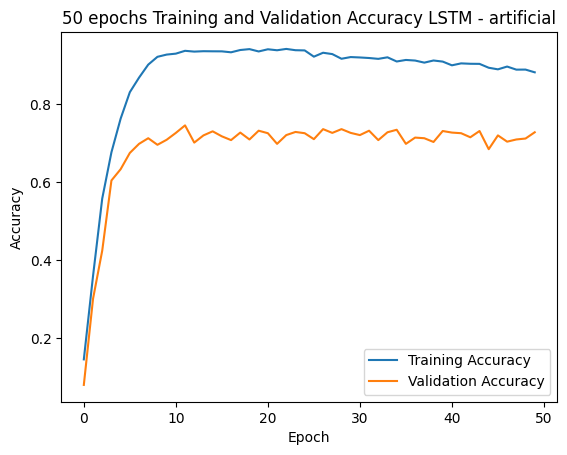

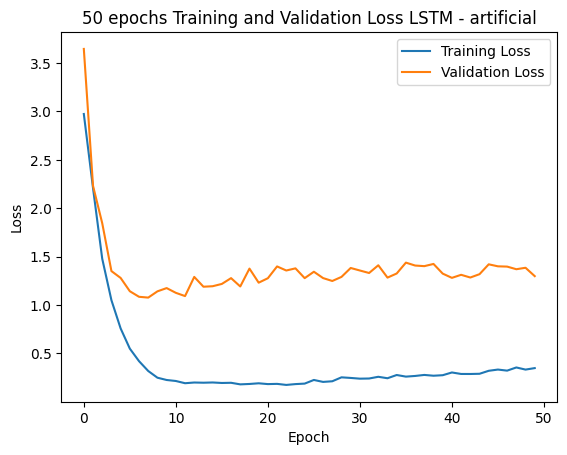

In [ ]:
process50EpochsResults(results, best, histories, model, titleComment)

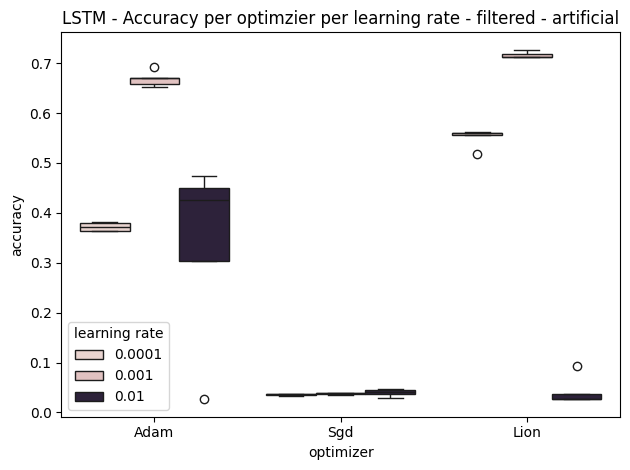

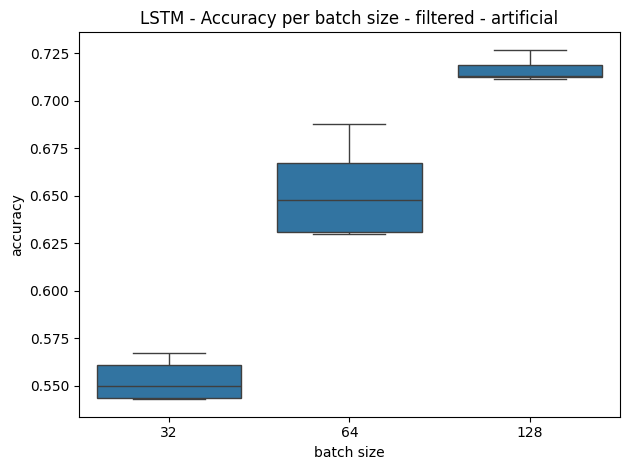

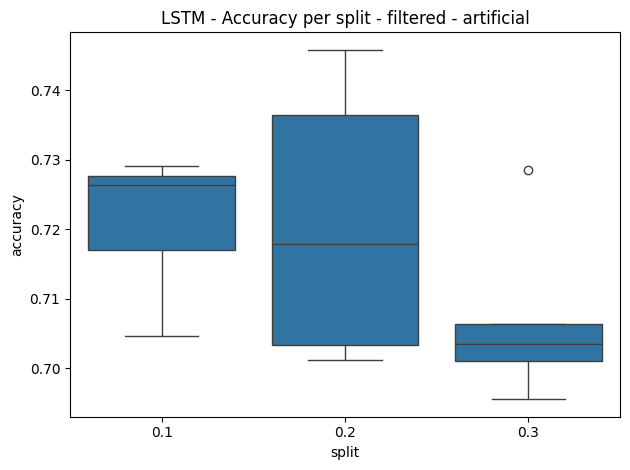

In [ ]:
processParametersFilteredResults(results, model, titleComment, best)

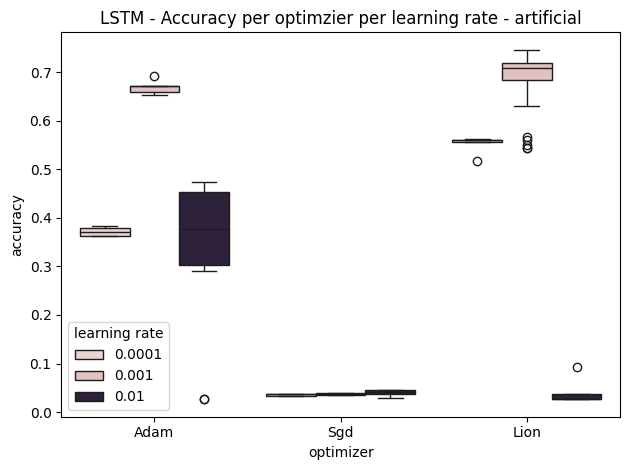

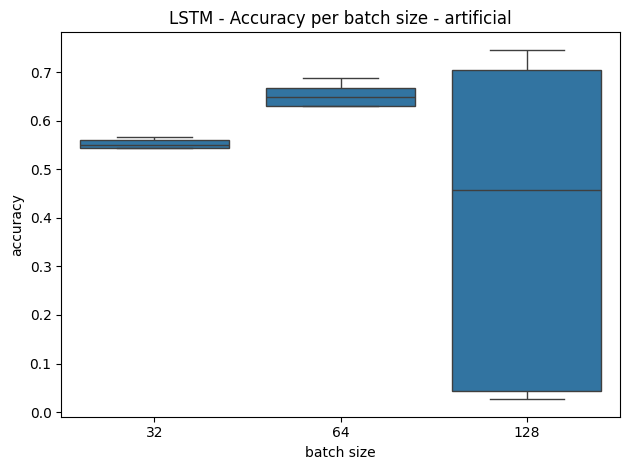

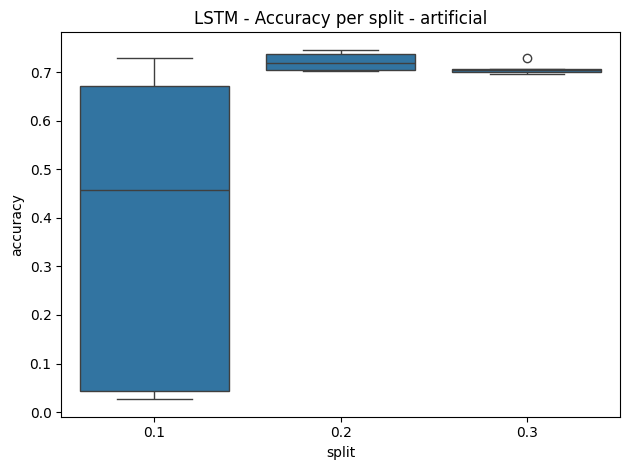

In [ ]:
processParametersResults(results, model, titleComment)

In [ ]:
bestDf = pd.DataFrame(
    [best],
    columns=[
        "accuracy",
        "batch size",
        "learning rate",
        "epochs",
        "augmentation",
        "optimizer",
        "split",
        "regularizer",
        "model",
        "seed",
    ],
)

In [ ]:
bestDf.head()

,accuracy,batch size,learning rate,epochs,augmentation,optimizer,split,regularizer,model,seed
0,0.691559,128,0.001,10,AugmentationTechnique.NoAugmentation,OptimizerType.Lion,0.1,"{'type': RegularizationType.NoRegularization, ...",ModelType.LSTM,4


In [ ]:
batchSize = bestDf["batch size"][0]

set_seed(42)
train_split_dataset, val_split_dataset = train_test_split(
    data, stratify=data["label"], test_size=0.1
)
train_split_dataset, test_split_dataset = train_test_split(
    train_split_dataset,
    stratify=train_split_dataset["label"],
    test_size=bestDf["split"][0],
)
# train_split_dataset.head(int(len(train_split_dataset)/20))
trainDataGenerator = getDatasetGenerator(
    model, train_split_dataset, num_classes, batchSize
)
valDataGenerator = getDatasetGenerator(model, val_split_dataset, num_classes, batchSize)
testDataGenerator = getDatasetGenerator(
    model, test_split_dataset, num_classes, batchSize
)

y_true = []
for index, row in test_split_dataset.iterrows():
    y_true.append(row["label"])

# Switching to Adam instead of Lion, on larger dataset Adam seems to be better
createModelArgs = {
    "modelType": model,
    "optimizer": getOptimizer(
        optimizer_type=OptimizerType.Adam, learningRate=bestDf["learning rate"][0]
    ),
    "regularizer": {
        "type": bestDf["regularizer"][0]["type"],
        "value": bestDf["regularizer"][0]["value"],
    },
    "loss": "categorical_crossentropy",
    "metrics": ["accuracy"],
    "augmentation": bestDf["augmentation"][0],
    "seed": bestDf["seed"][0],
    "num_classes": num_classes,
}
fitModelArgs = {
    "batch_size": batchSize,
    "epochs": 10,
    "train_dataset": trainDataGenerator,
    "val_dataset": valDataGenerator,
}

Epoch 1/10
410/410 [==============================] - 113s 232ms/step - loss: 1.7301 - accuracy: 0.4956 - val_loss: 0.8773 - val_accuracy: 0.7437
Epoch 2/10
410/410 [==============================] - 94s 230ms/step - loss: 0.7302 - accuracy: 0.7831 - val_loss: 0.6215 - val_accuracy: 0.8183
Epoch 3/10
410/410 [==============================] - 93s 228ms/step - loss: 0.5377 - accuracy: 0.8374 - val_loss: 0.5558 - val_accuracy: 0.8347
Epoch 4/10
410/410 [==============================] - 94s 230ms/step - loss: 0.4382 - accuracy: 0.8680 - val_loss: 0.5256 - val_accuracy: 0.8441
Epoch 5/10
410/410 [==============================] - 94s 230ms/step - loss: 0.3769 - accuracy: 0.8855 - val_loss: 0.4867 - val_accuracy: 0.8563
Epoch 6/10
410/410 [==============================] - 94s 229ms/step - loss: 0.3281 - accuracy: 0.9012 - val_loss: 0.4999 - val_accuracy: 0.8543
Epoch 7/10
410/410 [==============================] - 94s 229ms/step - loss: 0.2881 - accuracy: 0.9125 - val_loss: 0.5170 - val_a

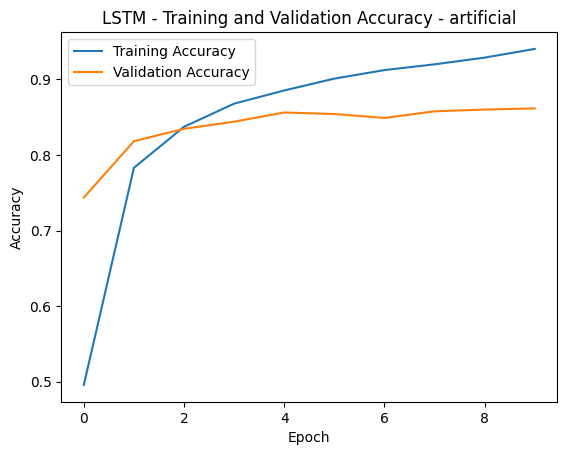

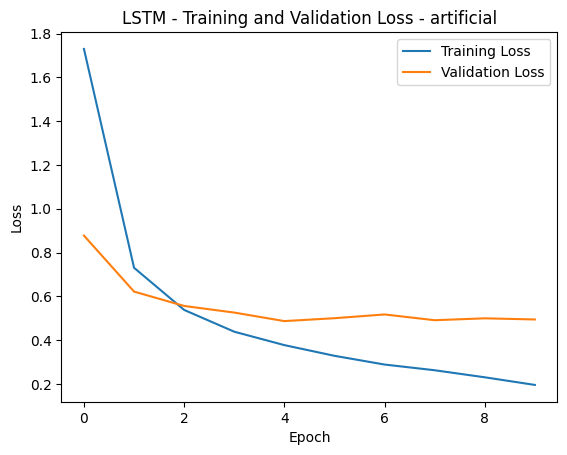

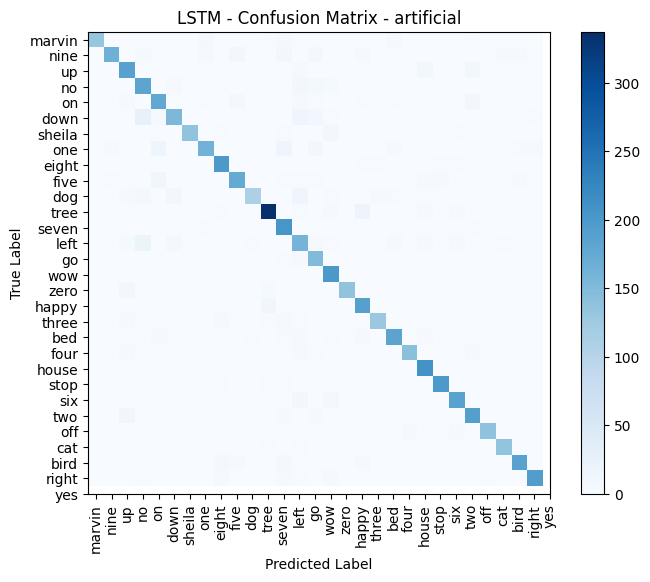

Accuracy: 0.865579399141631
CPU times: user 15min 49s, sys: 54.2 s, total: 16min 43s
Wall time: 16min 11s


In [ ]:
%%time
finalModelTest(
    createModelArgs, fitModelArgs, testDataGenerator, y_true, titleComment, labels
)

### LSTM - on a dataset with split background noise

In [ ]:
model = ModelType.LSTM
titleComment = " - artificial"
if IS_IN_COLAB:
    with open(r"/content/best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)
else:
    with open(r"best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)

titleComment = " - with bg noise"

In [ ]:
bestDf = pd.DataFrame(
    [best],
    columns=[
        "accuracy",
        "batch size",
        "learning rate",
        "epochs",
        "augmentation",
        "optimizer",
        "split",
        "regularizer",
        "model",
        "seed",
    ],
)

In [ ]:
batchSize = bestDf["batch size"][0]

set_seed(42)
train_split_dataset, val_split_dataset = train_test_split(
    dfBackgroundNoise_new, stratify=dfBackgroundNoise_new["label"], test_size=0.1
)
train_split_dataset, test_split_dataset = train_test_split(
    train_split_dataset,
    stratify=train_split_dataset["label"],
    test_size=bestDf["split"][0],
)
# train_split_dataset.head(int(len(train_split_dataset)/20))
trainDataGenerator = getDatasetGenerator(
    model, train_split_dataset, num_classes_with_bg_noise, batchSize
)
valDataGenerator = getDatasetGenerator(
    model, val_split_dataset, num_classes_with_bg_noise, batchSize
)
testDataGenerator = getDatasetGenerator(
    model, test_split_dataset, num_classes_with_bg_noise, batchSize
)

y_true = []
for index, row in test_split_dataset.iterrows():
    y_true.append(row["label"])

# Switching to Adam instead of Lion, on larger dataset Adam seems to be better
createModelArgs = {
    "modelType": model,
    "optimizer": getOptimizer(
        optimizer_type=OptimizerType.Adam, learningRate=bestDf["learning rate"][0]
    ),
    "regularizer": {
        "type": bestDf["regularizer"][0]["type"],
        "value": bestDf["regularizer"][0]["value"],
    },
    "loss": "categorical_crossentropy",
    "metrics": ["accuracy"],
    "augmentation": bestDf["augmentation"][0],
    "seed": bestDf["seed"][0],
    "num_classes": num_classes_with_bg_noise,
}
fitModelArgs = {
    "batch_size": batchSize,
    "epochs": 10,
    "train_dataset": trainDataGenerator,
    "val_dataset": valDataGenerator,
}

Epoch 1/10
397/397 [==============================] - 94s 230ms/step - loss: 1.7423 - accuracy: 0.4960 - val_loss: 0.9202 - val_accuracy: 0.7326
Epoch 2/10
397/397 [==============================] - 91s 228ms/step - loss: 0.7303 - accuracy: 0.7860 - val_loss: 0.6533 - val_accuracy: 0.8087
Epoch 3/10
397/397 [==============================] - 91s 229ms/step - loss: 0.5390 - accuracy: 0.8406 - val_loss: 0.5438 - val_accuracy: 0.8372
Epoch 4/10
397/397 [==============================] - 91s 230ms/step - loss: 0.4362 - accuracy: 0.8690 - val_loss: 0.5199 - val_accuracy: 0.8406
Epoch 5/10
397/397 [==============================] - 91s 229ms/step - loss: 0.3701 - accuracy: 0.8885 - val_loss: 0.4834 - val_accuracy: 0.8546
Epoch 6/10
397/397 [==============================] - 91s 230ms/step - loss: 0.3203 - accuracy: 0.9040 - val_loss: 0.4595 - val_accuracy: 0.8628
Epoch 7/10
397/397 [==============================] - 91s 230ms/step - loss: 0.2900 - accuracy: 0.9114 - val_loss: 0.4642 - val_ac

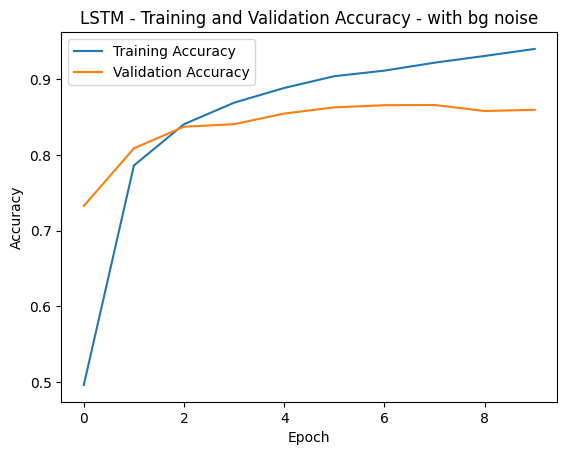

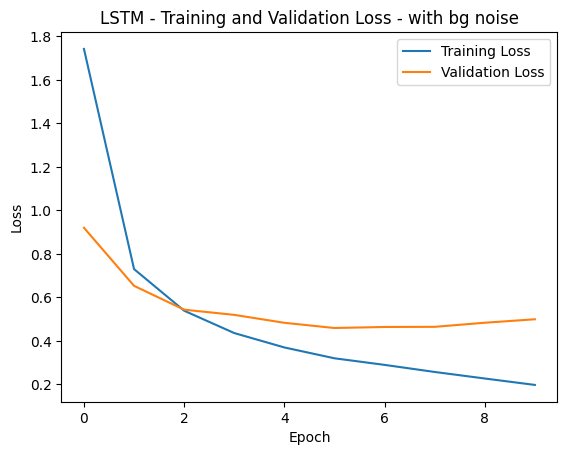

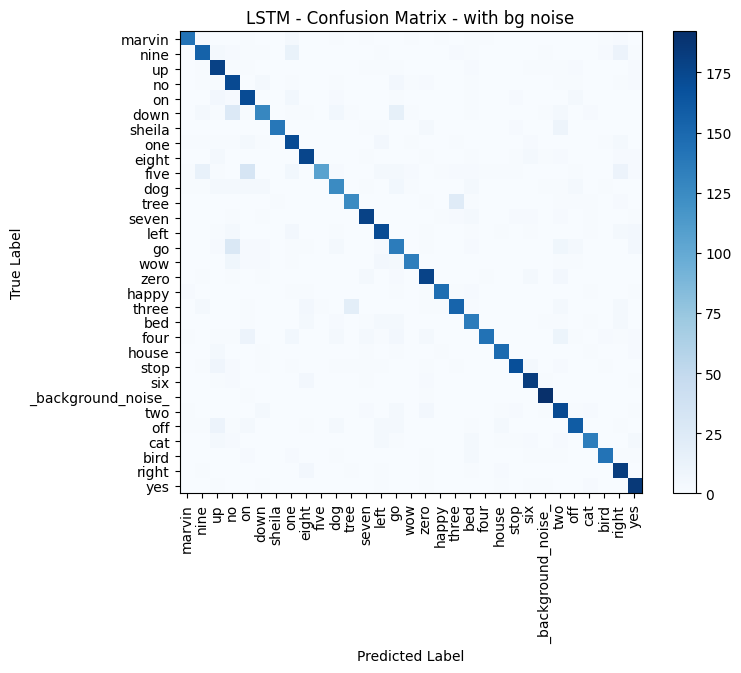

Accuracy: 0.8556993440879277
CPU times: user 15min 9s, sys: 51.1 s, total: 16min 1s
Wall time: 15min 26s


In [ ]:
%%time
finalAcc = finalModelTest(
    createModelArgs,
    fitModelArgs,
    testDataGenerator,
    y_true,
    titleComment,
    labelsBackgroundNoise,
)

### LSTM on a filtered dataset

In [ ]:
model = ModelType.LSTM_BG
titleComment = " - whole"
if IS_IN_COLAB:
    with open(
        r"/content/results-" + str(model.name) + titleComment, "rb"
    ) as input_file:
        results = pickle.load(input_file)

    with open(r"/content/best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)

    with open(
        r"/content/histories-" + str(model.name) + titleComment, "rb"
    ) as input_file:
        histories = pickle.load(input_file)
else:
    with open(r"results-" + str(model.name) + titleComment, "rb") as input_file:
        results = pickle.load(input_file)

    with open(r"best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)

    with open(r"histories-" + str(model.name) + titleComment, "rb") as input_file:
        histories = pickle.load(input_file)

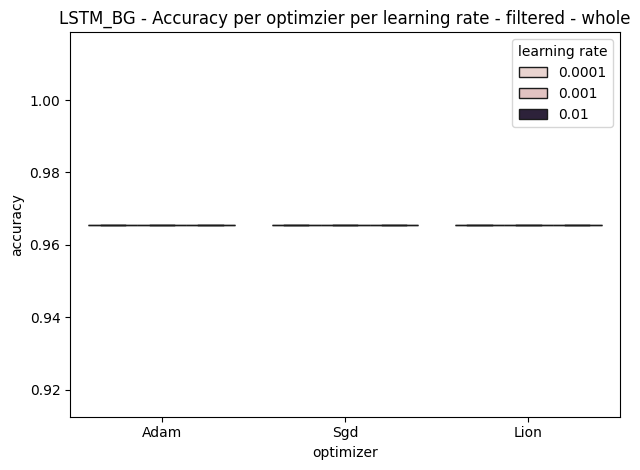

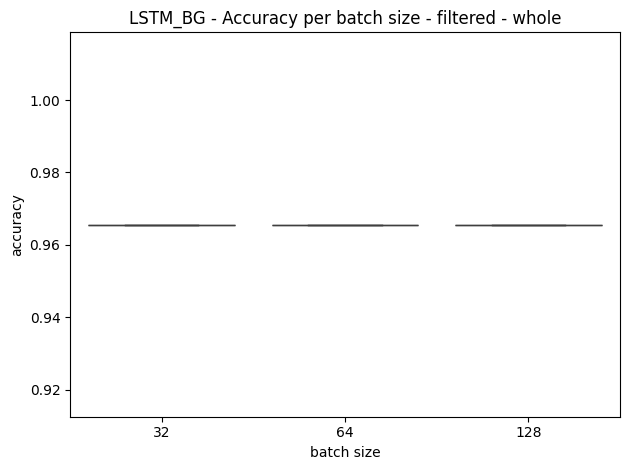

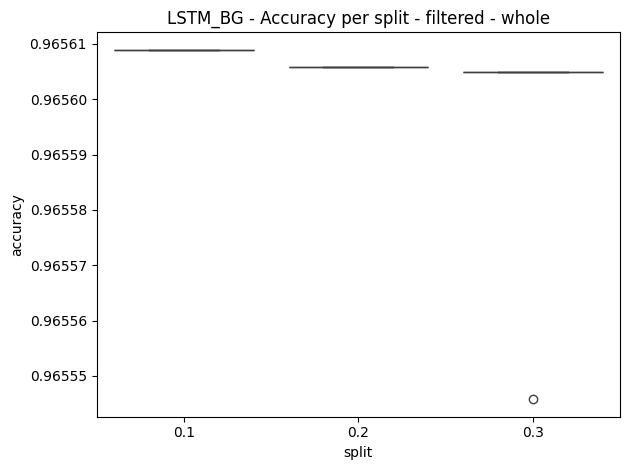

In [ ]:
processParametersFilteredResults(results, model, titleComment, best)

In [ ]:
bestDf = pd.DataFrame(
    [best],
    columns=[
        "accuracy",
        "batch size",
        "learning rate",
        "epochs",
        "augmentation",
        "optimizer",
        "split",
        "regularizer",
        "model",
        "seed",
    ],
)

In [ ]:
bestDf.head()

,accuracy,batch size,learning rate,epochs,augmentation,optimizer,split,regularizer,model,seed
0,0.965605,128,0.01,10,AugmentationTechnique.NoAugmentation,OptimizerType.Adam,0.1,"{'type': RegularizationType.NoRegularization, ...",ModelType.LSTM_BG,123


In [ ]:
batchSize = 256  # bestDf['batch size'][0]
learningRate = 0.00001  # bestDf['learning rate'][0]
set_seed(42)
train_split_dataset, val_split_dataset = train_test_split(
    normalisedBinaryBackgroundNoise,
    stratify=normalisedBinaryBackgroundNoise["label"],
    test_size=0.2,
)
train_split_dataset, test_split_dataset = train_test_split(
    train_split_dataset, stratify=train_split_dataset["label"], test_size=0.2
)
# train_split_dataset.head(int(len(train_split_dataset)/20))
trainDataGenerator = getDatasetGenerator(
    model, train_split_dataset, num_classes_with_bg_noise, batchSize
)
valDataGenerator = getDatasetGenerator(
    model, val_split_dataset, num_classes_with_bg_noise, batchSize
)
testDataGenerator = getDatasetGenerator(
    model, test_split_dataset, num_classes_with_bg_noise, batchSize
)
y_true = []
for index, row in test_split_dataset.iterrows():
    if row["label_name"] == "_background_noise_":
        y_true.append(1)
    else:
        y_true.append(0)

# Switching to Adam instead of Lion, on a larger dataset Adam seems to be better
createModelArgs = {
    "modelType": model,
    "optimizer": getOptimizer(
        optimizer_type=OptimizerType.Adam, learningRate=learningRate
    ),
    "regularizer": {
        "type": bestDf["regularizer"][0]["type"],
        "value": bestDf["regularizer"][0]["value"],
    },
    "loss": "categorical_crossentropy",
    "metrics": ["accuracy"],
    "augmentation": bestDf["augmentation"][0],
    "seed": bestDf["seed"][0],
    "num_classes": 2,
}
fitModelArgs = {
    "batch_size": batchSize,
    "epochs": 5,
    "train_dataset": trainDataGenerator,
    "val_dataset": valDataGenerator,
}

Epoch 1/5
11/11 [==============================] - 8s 547ms/step - loss: 0.6872 - accuracy: 0.5565 - val_loss: 0.6847 - val_accuracy: 0.6227
Epoch 2/5
11/11 [==============================] - 5s 487ms/step - loss: 0.6777 - accuracy: 0.5815 - val_loss: 0.6770 - val_accuracy: 0.5440
Epoch 3/5
11/11 [==============================] - 5s 500ms/step - loss: 0.6662 - accuracy: 0.5608 - val_loss: 0.6698 - val_accuracy: 0.5150
Epoch 4/5
11/11 [==============================] - 5s 501ms/step - loss: 0.6572 - accuracy: 0.5398 - val_loss: 0.6628 - val_accuracy: 0.5093
Epoch 5/5
3/3 [==============================] - 1s 315ms/step


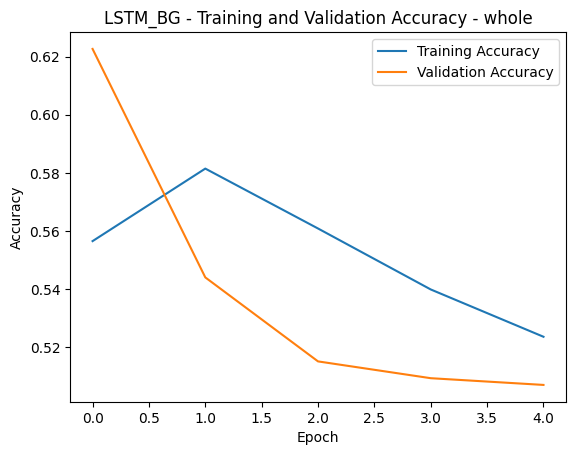

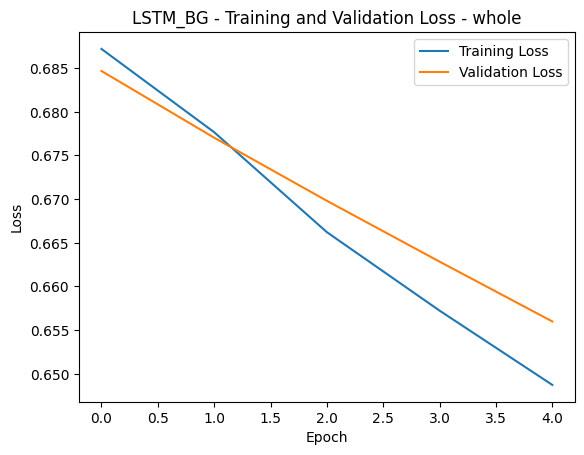

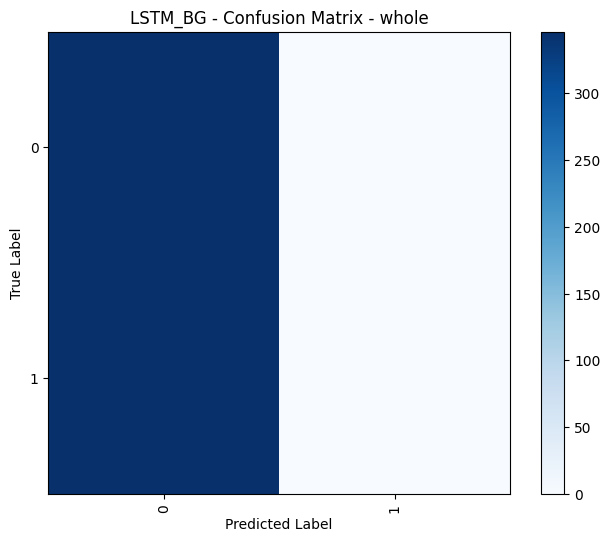

Accuracy: 0.5007235890014472
CPU times: user 32.3 s, sys: 2.17 s, total: 34.4 s
Wall time: 32.6 s


In [ ]:
%%time
filterDatasetModel = finalModelTest(
    createModelArgs, fitModelArgs, testDataGenerator, y_true, titleComment, [0, 1]
)

In [ ]:
# Filter the dataset
dfToFilter = dfBackgroundNoise_new.copy()
dataToFilterGenerator = getDatasetGenerator(
    model, dfToFilter, num_classes_with_bg_noise, batchSize
)

In [ ]:
%%time
predicted = filterDatasetModel.predict(dataToFilterGenerator)

490/490 [==============================] - 90s 3ms/step
CPU times: user 1min 26s, sys: 5.74 s, total: 1min 32s
Wall time: 1min 30s


In [ ]:
# There is no data shuffling involved so this should work just fine
for index, value in enumerate(predicted):
    if value == 1:
        dfToFilter = dfToFilter.drop(index)

In [ ]:
dfBackgroundNoise_new.shape[0]

62670

In [ ]:
dfToFilter.shape[0]

62670

In [ ]:
model = ModelType.LSTM

titleComment = " - artificial"
if IS_IN_COLAB:
    with open(r"/content/best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)
else:
    with open(r"best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)

titleComment = " - filtered"

In [ ]:
bestDf = pd.DataFrame(
    [best],
    columns=[
        "accuracy",
        "batch size",
        "learning rate",
        "epochs",
        "augmentation",
        "optimizer",
        "split",
        "regularizer",
        "model",
        "seed",
    ],
)

In [ ]:
bestDf.head()

In [ ]:
batchSize = bestDf["batch size"][0]

set_seed(42)
train_split_dataset, val_split_dataset = train_test_split(
    data, stratify=data["label"], test_size=0.1
)
train_split_dataset, test_split_dataset = train_test_split(
    train_split_dataset,
    stratify=train_split_dataset["label"],
    test_size=bestDf["split"][0],
)
# train_split_dataset.head(int(len(train_split_dataset)/20))
trainDataGenerator = getDatasetGenerator(
    model, train_split_dataset, num_classes, batchSize
)
valDataGenerator = getDatasetGenerator(model, val_split_dataset, num_classes, batchSize)
testDataGenerator = getDatasetGenerator(
    model, test_split_dataset, num_classes, batchSize
)

y_true = []
for index, row in test_split_dataset.iterrows():
    y_true.append(row["label"])

# Switching to Adam instead of Lion, on larger dataset Adam seems to be better
createModelArgs = {
    "modelType": model,
    "optimizer": getOptimizer(
        optimizer_type=OptimizerType.Adam, learningRate=bestDf["learning rate"][0]
    ),
    "regularizer": {
        "type": bestDf["regularizer"][0]["type"],
        "value": bestDf["regularizer"][0]["value"],
    },
    "loss": "categorical_crossentropy",
    "metrics": ["accuracy"],
    "augmentation": bestDf["augmentation"][0],
    "seed": bestDf["seed"][0],
    "num_classes": num_classes,
}
fitModelArgs = {
    "batch_size": batchSize,
    "epochs": 10,
    "train_dataset": trainDataGenerator,
    "val_dataset": valDataGenerator,
}

In [ ]:
%%time
finalModelTest(
    createModelArgs, fitModelArgs, testDataGenerator, y_true, titleComment, labels
)

### LSTM - short - without bg noise

In [67]:
model = ModelType.LSTM
titleComment = " - artificial"
if IS_IN_COLAB:
    with open(r"/content/best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)
else:
    with open(r"best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)

titleComment = " - with bg noise"
model = ModelType.CustomLSTMShort

In [68]:
bestDf = pd.DataFrame(
    [best],
    columns=[
        "accuracy",
        "batch size",
        "learning rate",
        "epochs",
        "augmentation",
        "optimizer",
        "split",
        "regularizer",
        "model",
        "seed",
    ],
)

In [69]:
batchSize = bestDf["batch size"][0]

set_seed(42)
train_split_dataset, val_split_dataset = train_test_split(
    data, stratify=data["label"], test_size=0.1
)
train_split_dataset, test_split_dataset = train_test_split(
    train_split_dataset,
    stratify=train_split_dataset["label"],
    test_size=bestDf["split"][0],
)
# train_split_dataset.head(int(len(train_split_dataset)/20))
trainDataGenerator = getDatasetGenerator(
    model, train_split_dataset, num_classes, batchSize
)
valDataGenerator = getDatasetGenerator(model, val_split_dataset, num_classes, batchSize)
testDataGenerator = getDatasetGenerator(
    model, test_split_dataset, num_classes, batchSize
)

y_true = []
for index, row in test_split_dataset.iterrows():
    y_true.append(row["label"])

# Switching to Adam instead of Lion, on larger dataset Adam seems to be better
createModelArgs = {
    "modelType": model,
    "optimizer": getOptimizer(
        optimizer_type=OptimizerType.Adam, learningRate=bestDf["learning rate"][0]
    ),
    "regularizer": {
        "type": bestDf["regularizer"][0]["type"],
        "value": bestDf["regularizer"][0]["value"],
    },
    "loss": "categorical_crossentropy",
    "metrics": ["accuracy"],
    "augmentation": bestDf["augmentation"][0],
    "seed": bestDf["seed"][0],
    "num_classes": num_classes,
}
fitModelArgs = {
    "batch_size": batchSize,
    "epochs": 10,
    "train_dataset": trainDataGenerator,
    "val_dataset": valDataGenerator,
}

Epoch 1/10
410/410 [==============================] - 94s 224ms/step - loss: 1.5959 - accuracy: 0.5318 - val_loss: 0.9173 - val_accuracy: 0.7255
Epoch 2/10
410/410 [==============================] - 90s 218ms/step - loss: 0.8054 - accuracy: 0.7604 - val_loss: 0.7264 - val_accuracy: 0.7846
Epoch 3/10
410/410 [==============================] - 90s 220ms/step - loss: 0.6382 - accuracy: 0.8087 - val_loss: 0.6594 - val_accuracy: 0.8055
Epoch 4/10
410/410 [==============================] - 90s 219ms/step - loss: 0.5439 - accuracy: 0.8367 - val_loss: 0.6106 - val_accuracy: 0.8186
Epoch 5/10
410/410 [==============================] - 90s 220ms/step - loss: 0.4809 - accuracy: 0.8543 - val_loss: 0.5824 - val_accuracy: 0.8260
Epoch 6/10
410/410 [==============================] - 90s 219ms/step - loss: 0.4366 - accuracy: 0.8665 - val_loss: 0.5686 - val_accuracy: 0.8302
Epoch 7/10
410/410 [==============================] - 90s 221ms/step - loss: 0.3985 - accuracy: 0.8790 - val_loss: 0.5709 - val_ac

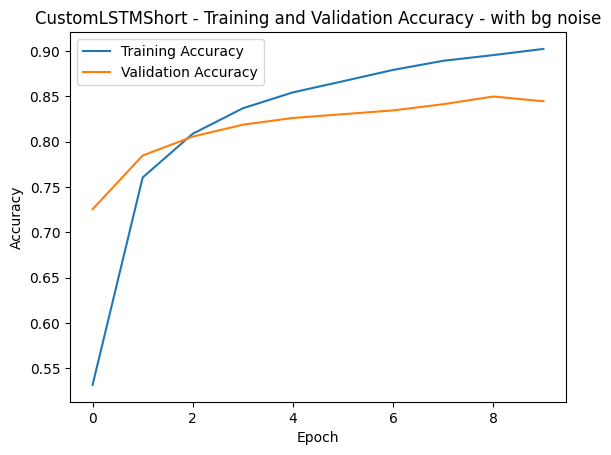

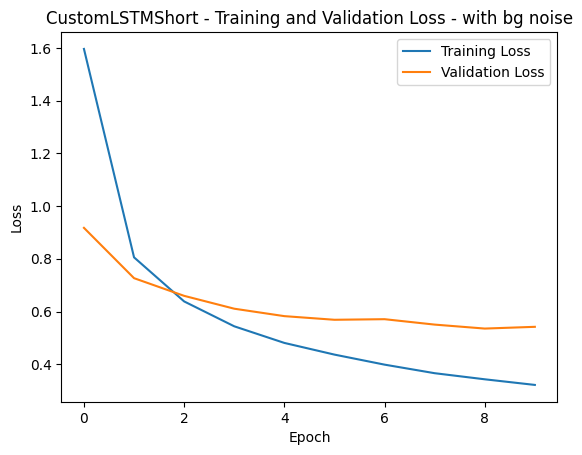

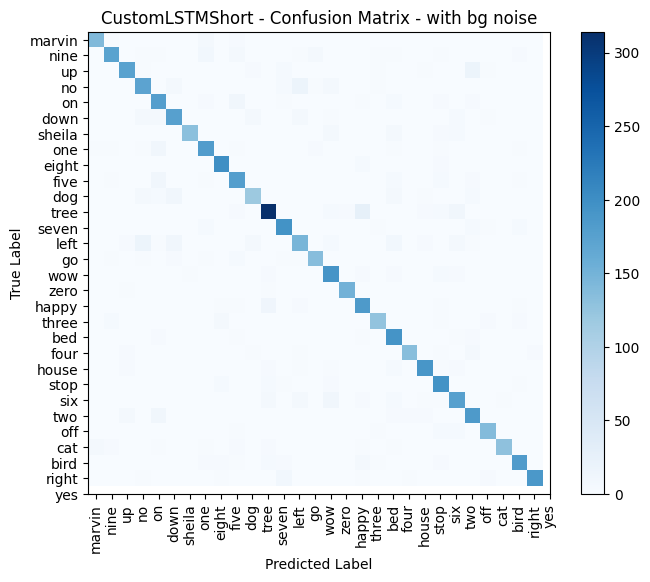

Accuracy: 0.8537339055793991
CPU times: user 14min 53s, sys: 53.6 s, total: 15min 47s
Wall time: 15min 16s


In [70]:
%%time
finalModelTest(
    createModelArgs, fitModelArgs, testDataGenerator, y_true, titleComment, labels
)

### LSTM - short - with bg noise

In [59]:
model = ModelType.LSTM
titleComment = " - artificial"
if IS_IN_COLAB:
    with open(r"/content/best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)
else:
    with open(r"best-" + str(model.name) + titleComment, "rb") as input_file:
        best = pickle.load(input_file)

titleComment = " - with bg noise"
model = ModelType.CustomLSTMShort

In [60]:
bestDf = pd.DataFrame(
    [best],
    columns=[
        "accuracy",
        "batch size",
        "learning rate",
        "epochs",
        "augmentation",
        "optimizer",
        "split",
        "regularizer",
        "model",
        "seed",
    ],
)

In [64]:
batchSize = bestDf["batch size"][0]

set_seed(42)
train_split_dataset, val_split_dataset = train_test_split(
    dfBackgroundNoise_new, stratify=dfBackgroundNoise_new["label"], test_size=0.1
)
train_split_dataset, test_split_dataset = train_test_split(
    train_split_dataset,
    stratify=train_split_dataset["label"],
    test_size=bestDf["split"][0],
)
# train_split_dataset.head(int(len(train_split_dataset)/20))
trainDataGenerator = getDatasetGenerator(
    model, train_split_dataset, num_classes_with_bg_noise, batchSize
)
valDataGenerator = getDatasetGenerator(
    model, val_split_dataset, num_classes_with_bg_noise, batchSize
)
testDataGenerator = getDatasetGenerator(
    model, test_split_dataset, num_classes_with_bg_noise, batchSize
)

y_true = []
for index, row in test_split_dataset.iterrows():
    y_true.append(row["label"])

# Switching to Adam instead of Lion, on larger dataset Adam seems to be better
createModelArgs = {
    "modelType": model,
    "optimizer": getOptimizer(
        optimizer_type=OptimizerType.Adam, learningRate=bestDf["learning rate"][0]
    ),
    "regularizer": {
        "type": bestDf["regularizer"][0]["type"],
        "value": bestDf["regularizer"][0]["value"],
    },
    "loss": "categorical_crossentropy",
    "metrics": ["accuracy"],
    "augmentation": bestDf["augmentation"][0],
    "seed": bestDf["seed"][0],
    "num_classes": num_classes_with_bg_noise,
}
fitModelArgs = {
    "batch_size": batchSize,
    "epochs": 10,
    "train_dataset": trainDataGenerator,
    "val_dataset": valDataGenerator,
}

Epoch 1/10
397/397 [==============================] - 91s 222ms/step - loss: 1.6319 - accuracy: 0.5296 - val_loss: 1.0045 - val_accuracy: 0.7062
Epoch 2/10
397/397 [==============================] - 87s 220ms/step - loss: 0.7908 - accuracy: 0.7677 - val_loss: 0.7144 - val_accuracy: 0.7905
Epoch 3/10
397/397 [==============================] - 88s 221ms/step - loss: 0.6228 - accuracy: 0.8169 - val_loss: 0.6320 - val_accuracy: 0.8131
Epoch 4/10
397/397 [==============================] - 88s 221ms/step - loss: 0.5329 - accuracy: 0.8429 - val_loss: 0.6221 - val_accuracy: 0.8147
Epoch 5/10
397/397 [==============================] - 89s 224ms/step - loss: 0.4735 - accuracy: 0.8605 - val_loss: 0.5759 - val_accuracy: 0.8294
Epoch 6/10
397/397 [==============================] - 89s 223ms/step - loss: 0.4301 - accuracy: 0.8724 - val_loss: 0.5768 - val_accuracy: 0.8296
Epoch 7/10
397/397 [==============================] - 92s 231ms/step - loss: 0.3915 - accuracy: 0.8824 - val_loss: 0.5511 - val_ac

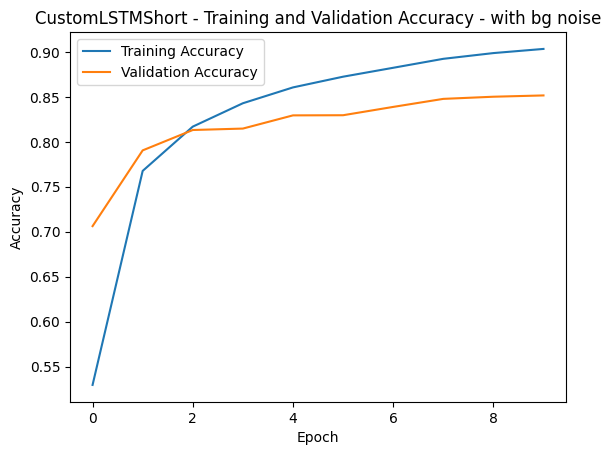

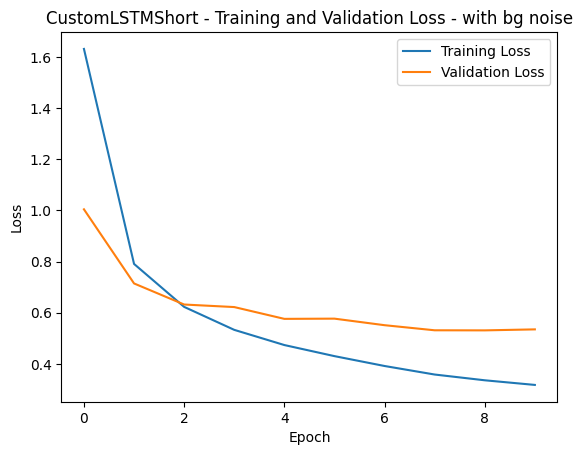

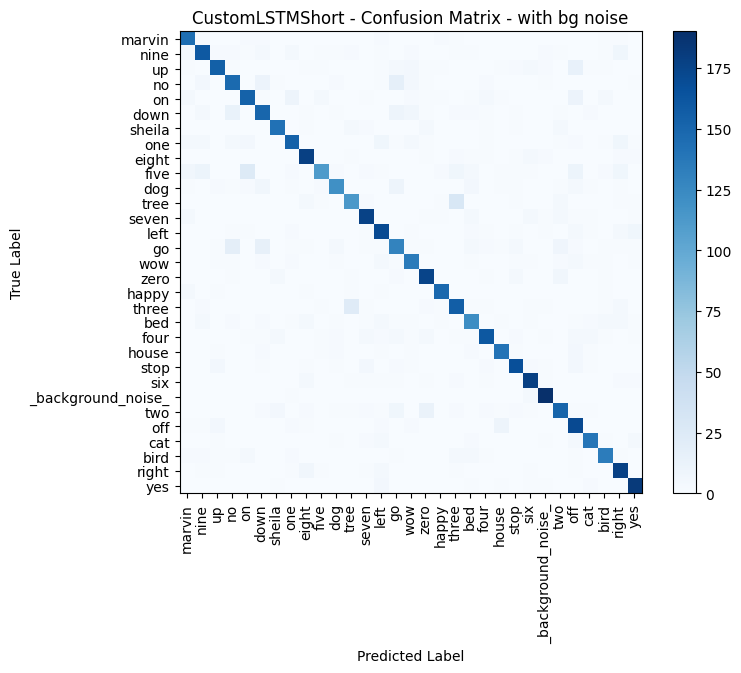

Accuracy: 0.8383265378478993
CPU times: user 14min 37s, sys: 52.2 s, total: 15min 29s
Wall time: 14min 59s


In [65]:
%%time
finalAcc = finalModelTest(
    createModelArgs,
    fitModelArgs,
    testDataGenerator,
    y_true,
    titleComment,
    labelsBackgroundNoise,
)

## Whisper

In [ ]:
modelType = "Whisper"

### Whisper - Dataset with split background noise

In [ ]:
_, test_df = train_test_split(
    dfBackgroundNoise_new, stratify=dfBackgroundNoise_new["label"], test_size=0.1
)

In [ ]:
dfBackgroundNoise_new.groupby("label_name").count()

,label,path
label_name,,
_background_noise_,2157,2157
bed,1713,1713
bird,1731,1731
cat,1733,1733
dog,1746,1746
down,2157,2157
eight,2157,2157
five,2157,2157
four,2157,2157


In [ ]:
test_df.groupby("label_name").count()

,label,path
label_name,,
_background_noise_,216,216
bed,171,171
bird,173,173
cat,173,173
dog,174,174
down,216,216
eight,216,216
five,216,216
four,216,216


In [ ]:
%%time
correct_predictions = 0
model = WhisperModel("base.en", device="auto", compute_type="float32")
test_df.apply(predict_with_whisper_on_row, axis=1)
print("Accuracy:", correct_predictions / len(test_df))

Accuracy: 0.8418701132918461
CPU times: user 34min 10s, sys: 1h 11min 16s, total: 1h 45min 26s
Wall time: 22min 7s


In [ ]:
titleComment = " - whole"
with open("correctpredictions-" + str(modelType) + titleComment, "wb") as my_csv:
    pickle.dump(correct_predictions, my_csv)

if IS_IN_COLAB:
    shutil.copy(
        "/content/correctpredictions-" + str(modelType) + titleComment,
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
    )

### Dataset with artificially removed background noise

In [ ]:
_, test_df = train_test_split(data, stratify=data["label"], test_size=0.1)

In [ ]:
%%time
correct_predictions = 0
model = WhisperModel("base.en", device="auto", compute_type="float32")
test_df.apply(predict_with_whisper_on_row, axis=1)
print("Accuracy:", correct_predictions / len(test_df))

Accuracy: 0.8648231113857562
CPU times: user 35min 48s, sys: 1h 13min 25s, total: 1h 49min 13s
Wall time: 23min 13s


In [ ]:
titleComment = " - artificial"
with open("correctpredictions-" + str(modelType) + titleComment, "wb") as my_csv:
    pickle.dump(correct_predictions, my_csv)

if IS_IN_COLAB:
    shutil.copy(
        "/content/correctpredictions-" + str(modelType) + titleComment,
        "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/",
    )

# CAREFUL: Disconnect from colab

In [ ]:
if IS_IN_COLAB:
    from google.colab import runtime

    runtime.unassign()